<a href="https://colab.research.google.com/github/business-ui/python_projects/blob/master/NYC_Rolling_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

In [2]:
import tensorflow as tf  # now import the tensorflow module
print(tf.version)  # make sure the version is 2.x

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
from scipy import stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from sklearn.model_selection import train_test_split, cross_val_score

In [5]:
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
df = pd.read_csv("/content/nyc-rolling-sales.csv", parse_dates=True)

In [7]:
df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,10009,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,10009,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [8]:
df.columns

Index(['Unnamed: 0', 'BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object')

In [9]:
del df['Unnamed: 0']
del df['APARTMENT NUMBER']

In [10]:
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'], infer_datetime_format=True)
df['TAX CLASS AT TIME OF SALE'] = df['TAX CLASS AT TIME OF SALE'].astype('category')
df['TAX CLASS AT PRESENT'] = df['TAX CLASS AT PRESENT'].astype('category')
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')
df['BOROUGH'] = df['BOROUGH'].astype('category')

In [11]:
df.columns = df.columns.str.replace(" ","_").str.lower()

In [12]:
df.dtypes

borough                                 category
neighborhood                              object
building_class_category                   object
tax_class_at_present                    category
block                                      int64
lot                                        int64
ease-ment                                 object
building_class_at_present                 object
address                                   object
zip_code                                   int64
residential_units                          int64
commercial_units                           int64
total_units                                int64
land_square_feet                         float64
gross_square_feet                        float64
year_built                                 int64
tax_class_at_time_of_sale               category
building_class_at_time_of_sale            object
sale_price                               float64
sale_date                         datetime64[ns]
dtype: object

In [13]:
miss=df.isnull().sum()/len(df)
miss=miss[miss>0]
miss.sort_values(inplace=True)
miss.columns=["name","count"]

<module 'seaborn' from '/usr/local/lib/python3.6/dist-packages/seaborn/__init__.py'>

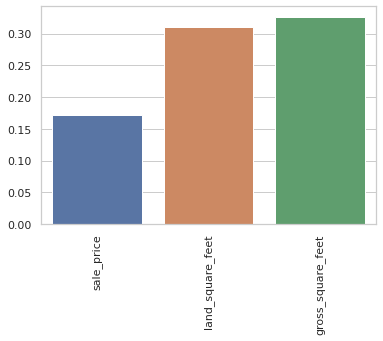

In [14]:
sns.set(style='whitegrid',color_codes=True)
sns.barplot(x=miss.index, y=miss.values)
plt.xticks(rotation=90)
sns

In [15]:
# let's fill these missing values up with mean values.
df['land_square_feet']=df['land_square_feet'].fillna(df['land_square_feet'].mean())
df['gross_square_feet']=df['gross_square_feet'].fillna(df['gross_square_feet'].mean())

In [16]:
# I want to add the weekday and month features to the dataset. January sales can differ from July sales.
df['weekday'] = df['sale_date'].apply(lambda x: datetime.datetime.weekday(x))
df['sale_day'] = pd.DatetimeIndex(df['sale_date']).day
df['sale_month'] = pd.DatetimeIndex(df['sale_date']).month
df['sale_year'] = pd.DatetimeIndex(df['sale_date']).year
del df['sale_date']

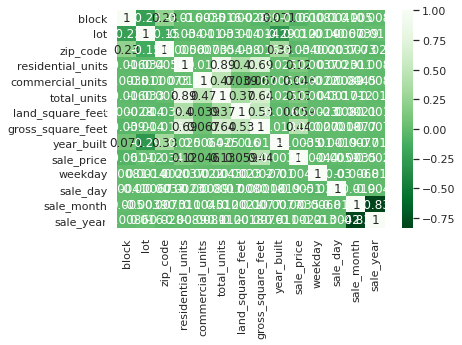

In [17]:
sns.heatmap(df.corr(),annot=True,cmap="Greens_r")

In [18]:
# For a numeric representation of correlation with sale_price
df.corr()['sale_price'].sort_values(ascending=False)

sale_price           1.000000
gross_square_feet    0.444508
total_units          0.125101
residential_units    0.119698
land_square_feet     0.059079
commercial_units     0.046006
lot                  0.012324
weekday              0.004376
sale_month           0.003461
sale_year           -0.002167
year_built          -0.003539
sale_day            -0.005103
zip_code            -0.034170
block               -0.061139
Name: sale_price, dtype: float64

In [19]:
df.head()

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,ease-ment,building_class_at_present,address,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,weekday,sale_day,sale_month,sale_year
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,10009,5,0,5,1633.0,6440.0,1900,2,C2,6625000.0,2,19,7,2017
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,10009,28,3,31,4616.0,18690.0,1900,2,C7,NaN,2,14,12,2016
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,10009,16,1,17,2212.0,7803.0,1900,2,C7,NaN,4,9,12,2016
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,10009,10,0,10,2272.0,6794.0,1913,2,C4,3936272.0,4,23,9,2016
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,10009,6,0,6,2369.0,4615.0,1900,2,C2,8000000.0,3,17,11,2016


In [20]:
# separating the tax_class_at_present column into number and letter columns for comparison with tax_class_at_time_of_sale (Boolean)
df['tax_class_at_present'], df['tax_class_at_present_letter'] = df['tax_class_at_present'].str[0], df['tax_class_at_present'].str[1]
df['tax_class_at_present_letter'].loc[df['tax_class_at_present_letter'].isna()] = 0

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [21]:
# setting blank tax_class_at_present values to the tax_class_at_time_of_sale
# same for building_class columns
# this makes an assumption, but a reasonable one, that they are the same if the present value is blank
df.loc[df['tax_class_at_present']==" ", 'tax_class_at_present'] = df.loc[df['tax_class_at_present']==" ", 'tax_class_at_time_of_sale']
df.loc[df['building_class_at_present']==" ", "building_class_at_present"] = df.loc[df['building_class_at_present']==" ", "building_class_at_time_of_sale"]

In [22]:
for col in df[['tax_class_at_present','tax_class_at_time_of_sale','building_class_at_present','building_class_at_time_of_sale']]:
    print(col)
    df[col] = df[col].astype(str).str.strip()

tax_class_at_present
tax_class_at_time_of_sale
building_class_at_present
building_class_at_time_of_sale


In [23]:
df.loc[(df['tax_class_at_present']!=df['tax_class_at_time_of_sale']) & (df['tax_class_at_present'].str.lower()=="nan"),
       'tax_class_at_present'] = \
       df.loc[(df['tax_class_at_present']!=df['tax_class_at_time_of_sale']) & (df['tax_class_at_present'].str.lower()=="nan"),
       'tax_class_at_time_of_sale']

df.loc[(df['building_class_at_present']!=df['building_class_at_time_of_sale']) & (df['building_class_at_present'].str.lower()=="nan"),
       'building_class_at_present'] = \
       df.loc[(df['building_class_at_present']!=df['building_class_at_time_of_sale']) & (df['building_class_at_present'].str.lower()=="nan"),
       'building_class_at_time_of_sale']

In [24]:
df['tax_class_stays_same'] = (df['tax_class_at_present']==df['tax_class_at_time_of_sale']).astype("int")
df['building_class_stays_same'] = (df['building_class_at_present']==df['building_class_at_time_of_sale']).astype("int")

In [25]:
# have to get close with street addresses. accuracy here can be best found with an address searching algorithm.
df['address'] = df['address'].str.split(",",n=1,expand=True)[0].str.split(" ",n=1,expand=True)[1]

In [26]:
df.columns

Index(['borough', 'neighborhood', 'building_class_category',
       'tax_class_at_present', 'block', 'lot', 'ease-ment',
       'building_class_at_present', 'address', 'zip_code', 'residential_units',
       'commercial_units', 'total_units', 'land_square_feet',
       'gross_square_feet', 'year_built', 'tax_class_at_time_of_sale',
       'building_class_at_time_of_sale', 'sale_price', 'weekday', 'sale_day',
       'sale_month', 'sale_year', 'tax_class_at_present_letter',
       'tax_class_stays_same', 'building_class_stays_same'],
      dtype='object')

In [27]:
orig_data_length = len(df)
df = df[(df['sale_price'] > 100000) & (df['sale_price'] < 5000000)]
# df = df[df['gross_square_feet'] < 10000]
# df = df[df['land_square_feet'] < 10000]
# df = df[(df['total_units'] > 0) & (df['total_units'] != 2261)]
print("Percentage of original data left:",str(round((len(df)/orig_data_length)*100,1))+"%")
print("New Dataset Shape:",df.shape)

Percentage of original data left: 64.6%
New Dataset Shape: (54657, 26)


In [28]:
for col in df.select_dtypes(include=[np.number]).drop(['year_built','weekday','sale_month','sale_day','sale_year'], axis=1):
    outliers = np.where(
        np.abs(
            stats.zscore(
                df[col]
            )
        ) > 3 )[0]
    
    log_transformed_outliers = np.where(
        np.abs(
            stats.zscore(
                df[col].apply(
                    lambda x: np.log(x) if (x != 0) & (x != np.nan) else 1e-100
                )
            )
        ) > 3 )[0]
    
    print(df[col].name)
    print("outliers:",len(outliers))
    print("log transformed outliers:",len(log_transformed_outliers))
    print()
    if len(log_transformed_outliers) < len(outliers):
      df[col] = df[col].apply(lambda x: np.log(x) if (x != 0) & (x != np.nan) else 1e-20)

block
outliers: 651
log transformed outliers: 993

lot
outliers: 581
log transformed outliers: 0

zip_code
outliers: 494
log transformed outliers: 494

residential_units
outliers: 50
log transformed outliers: 938

commercial_units
outliers: 5
log transformed outliers: 453

total_units
outliers: 39
log transformed outliers: 931

land_square_feet
outliers: 27
log transformed outliers: 0

gross_square_feet
outliers: 50
log transformed outliers: 0

sale_price
outliers: 1567
log transformed outliers: 0

tax_class_stays_same
outliers: 13
log transformed outliers: 13

building_class_stays_same
outliers: 114
log transformed outliers: 114



0.1989281802313763


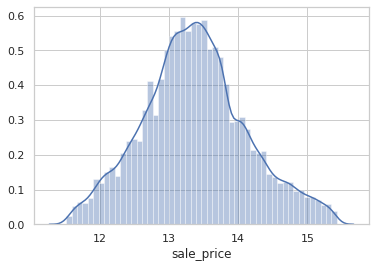

In [29]:
sales=df['sale_price']
print(sales.skew())
sns.distplot(sales)

In [30]:
df.dtypes

borough                           category
neighborhood                        object
building_class_category             object
tax_class_at_present                object
block                                int64
lot                                float64
ease-ment                           object
building_class_at_present           object
address                             object
zip_code                             int64
residential_units                    int64
commercial_units                     int64
total_units                          int64
land_square_feet                   float64
gross_square_feet                  float64
year_built                           int64
tax_class_at_time_of_sale           object
building_class_at_time_of_sale      object
sale_price                         float64
weekday                              int64
sale_day                             int64
sale_month                           int64
sale_year                            int64
tax_class_a

In [31]:
CATEGORICAL_COLUMNS = ['borough', 
                       'weekday', 
                       'sale_day',
                       'sale_month', 
                       'sale_year', 
                       'tax_class_at_present_letter',
                       'tax_class_stays_same',
                       'building_class_stays_same',
                       'tax_class_at_time_of_sale',
                       'building_class_at_time_of_sale',
                       'year_built',
                       'neighborhood',
                       'building_class_category',
                       'tax_class_at_present',
                       'block',
                       'lot',
                       'ease-ment',
                       'building_class_at_present', 
                       'address',
                       'zip_code']
NUMERIC_COLUMNS = ['residential_units','commercial_units', 'total_units', 'land_square_feet','gross_square_feet']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  df[feature_name] = df[feature_name].astype('str')
  vocabulary = df[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  df[feature_name] = df[feature_name].astype('float64')
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float64))

VocabularyListCategoricalColumn(key='borough', vocabulary_list=('1', '2', '3', '4', '5'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='weekday', vocabulary_list=('4', '3', '2', '0', '1', '5', '6'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='sale_day', vocabulary_list=('23', '10', '9', '14', '16', '1', '17', '30', '7', '21', '4', '18', '28', '2', '31', '24', '27', '11', '29', '5', '13', '6', '12', '3', '20', '8', '22', '25', '19', '15', '26'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='sale_month', vocabulary_list=('9', '3', '6', '7', '8', '1', '4', '5', '12', '10', '2', '11'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='sale_year', vocabulary_list=('2016', '2017'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='tax_class_at_present_letter', vocabulary_list=

In [32]:
dftrain, dfeval, y_train, y_eval = train_test_split(df,df.pop('sale_price'), test_size=0.25, random_state=42)

In [33]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)


In [34]:
estimator = tf.estimator.BoostedTreesRegressor(n_batches_per_layer=32,feature_columns=feature_columns,learning_rate=0.05)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpuw1_xxw7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [35]:
estimator.train(train_input_fn)  # train
result = estimator.evaluate(eval_input_fn)  # get model metrics/stats by evaluating testing data

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpuw1_xxw7/model.ckpt.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note thi

In [36]:
# RMSE
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))

In [37]:
pred_dicts = list(estimator.predict(eval_input_fn))

preds = pd.Series([pred['predictions'][0] for pred in pred_dicts])

actuals = y_eval.reset_index(drop=True)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpuw1_xxw7/model.ckpt-12778
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [38]:
print(actuals.head())
print(preds.head())

0    12.367341
1    13.715690
2    12.860999
3    12.959844
4    13.384728
Name: sale_price, dtype: float64
0    12.834978
1    13.598272
2    13.572056
3    13.056791
4    13.329354
dtype: float64


## Keep in mind that these are the log-transformed values of sale_price. 
## If you want to compute the errors with non-transformed values, use the following equation: 
## $$error = 10e^{actual} - 10e^{prediction}$$ 

In [39]:
result

{'average_loss': 0.25339755,
 'global_step': 12778,
 'label/mean': 13.384774,
 'loss': 0.25308064,
 'prediction/mean': 13.38624}

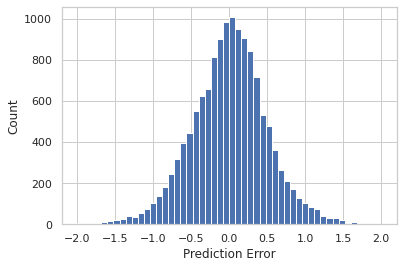

In [40]:
error = actuals - preds
plt.hist(error, bins = 50,range=(-2,2))
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

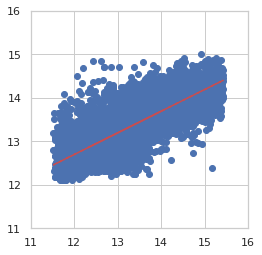

In [41]:
fig, ax = plt.subplots(nrows= 1, ncols = 1)

ax.scatter(x = actuals, y = preds)
ax.set_aspect("equal")
ax.set_xlim(11,16)
ax.set_ylim(11,16)
z = np.polyfit(actuals, preds, 1)
p = np.poly1d(z)
ax.plot(actuals, p(actuals),"r--")



fig.show()

In [42]:
print('R^2 score: {}'.format(r2_score(actuals, preds)))

print("Root Mean Squared Error: {}".format(rmse(actuals, preds)))

R^2 score: 0.5606086809725379
Root Mean Squared Error: 0.5033861225030037
